<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Obtaining-Data-from-a-PDF" data-toc-modified-id="Obtaining-Data-from-a-PDF-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Obtaining Data from a PDF</a></span></li><li><span><a href="#Additional-Database-Scrape-from-PDFs" data-toc-modified-id="Additional-Database-Scrape-from-PDFs-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Additional Database Scrape from PDFs</a></span></li></ul></li><li><span><a href="#EDA-and-Cleaning-Decisions" data-toc-modified-id="EDA-and-Cleaning-Decisions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA and Cleaning Decisions</a></span><ul class="toc-item"><li><span><a href="#Cleaning-Results" data-toc-modified-id="Cleaning-Results-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cleaning Results</a></span></li><li><span><a href="#FIPS-Data" data-toc-modified-id="FIPS-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>FIPS Data</a></span></li></ul></li></ul></div>

In [1]:
import PyPDF2
import glob
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
pd.set_option('display.max_columns', None)

## Obtaining Data from a PDF

So there is a head to this document and we need to remove it. Since it will not be standard slice (every state has a different length of a name), we will have to see if there are patterns between the documents that we can exploit.

In [2]:
# pdf file object
# you can find find the pdf file with complete code in below
pdfFileObj = open('data/state_pdfs/al-alpha.pdf', 'rb')
# pdf reader object
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
# number of pages in pdf
pages = pdfReader.numPages
pages

81

In [3]:
pageObj = pdfReader.getPage(0)
al = pageObj.extractText()

In [4]:
al

'U.S. Military Fatal Casualties of the Vietnam War for \nHome-State-of-Record: Alabama\nName\nService\nRank / \nRate\n   Birthdate \n(YYYYMMDD)\nIncident or \nDeath Date \n(YYYYMMDD)\nRemains \nRecovered\nHome of Record:\nCity                  County\nABRAMS TIMOTHY C JR\nARMY\nPFC\n19461104\nTUSCALOOSA\nTUSCALOOSA\n19670103\nY\nABSTON JAMES ESTUS JR\nARMY\nPFC\n19441102\nCOTTONDALE\nTUSCALOOSA\n19670227\nY\nACTON MARION \nFRANKLIN\nARMY\nPFC\n19470901\nHUNTSVILLE\nMADISON\n19660411\nY\nADAMS JAMES CONRAD\nARMY\nMAJ\n19381025\nPHENIX CITY\nRUSSELL\n19700501\nY\nADAMS SPENCER\nARMY\nSSG\n19340506\nMOBILE\nMOBILE\n19680215\nY\nADAMS WALTER LEE\nARMY\nPFC\n19461227\nMCINTOSH\nWASHINGTON\n19670610\nY\nADAMSON LARRY ONEAL\nARMY\nSP4\n19460910\nFAIRFAX\nCHAMBERS\n19691003\nY\nADDISON ONEAL\nARMY\nSP5\n19270506\nWEST ENSLEY\nJEFFERSON\n19660504\nY\nADKISON CARL ELMUS\nARMY\nSP4\n19490531\nGADSDEN\nETOWAH\n19690812\nY\nAKINS ADRIAN ALAN\nARMY\nSP5\n19490404\nCORDOVA\nWALKER\n19691025\nY\nALEXA

Proof of concept. Now let pull another one and compare the results.

In [5]:
# pdf file object
# you can find find the pdf file with complete code in below
pdfFileObj = open('data/state_pdfs/ak-alpha.pdf', 'rb')
# pdf reader object
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
# number of pages in pdf
pages = pdfReader.numPages
pages

5

In [6]:
pageObj = pdfReader.getPage(0)
ak = pageObj.extractText()

In [7]:
ak

'U.S. Military Fatal Casualties of the Vietnam War for \nHome-State-of-Record: Alaska\nName\nService\nRank / \nRate\n   Birthdate \n(YYYYMMDD)\nIncident or \nDeath Date \n(YYYYMMDD)\nRemains \nRecovered\nHome of Record:\nCity                  County\nANDERSON THOMAS \nEDWARD\nMARINE CORPS\nCPL\n19390727\nSPENARD\nANCHORAGE\n19621006\nN\nBANTA MICHAEL DEAN\nARMY\nPFC\n19491005\nCORDOVA\nVALDEZ-\nCORDOVA\n19701002\nY\nBARR EDWARD \nNASUESAK\nNAVY\nSN\n19491022\nBREVIG \nMISSION\nNOME\n19690503\nY\nBARR THOMAS M\nARMY\nSP5\n19450701\nANCHORAGE\nANCHORAGE\n19690512\nY\nBAUER RICHARD GENE\nARMY\nSP5\n19500619\nANCHORAGE\nANCHORAGE\n19691104\nY\nBETTS LARRY LE ROY\nARMY\n2LT\n19461011\nEAGLE RIVER\nANCHORAGE\n19691121\nY\nBROWN CHARLES \nEDWARD\nARMY\nPFC\n19421003\nTHORNE BAY\nPRINCE OF \nWALES-OUTER \nKETCHIKAN\n19671206\nY\nBROWN DAVID DEE JR\nMARINE CORPS\nPFC\n19491010\nWRANGELL\nWRANGELL-\nPETERSBURG\n19680416\nY\nBULLOCK GARY EDWIN\nARMY\nSP4\n19420918\nANCHORAGE\nANCHORAGE\n19670131\

___
For both of these records, all the data exists between the words "County" and "Source". I will grab everything in between the two words.
___

In [11]:
ak_soup = re.search(r"(?<=County\n).*(?=Source)", ak, flags=re.DOTALL) #re.DOTALL - makes the '.' special character match any character at all, including a newline
ak_soup.group(0)

'ANDERSON THOMAS \nEDWARD\nMARINE CORPS\nCPL\n19390727\nSPENARD\nANCHORAGE\n19621006\nN\nBANTA MICHAEL DEAN\nARMY\nPFC\n19491005\nCORDOVA\nVALDEZ-\nCORDOVA\n19701002\nY\nBARR EDWARD \nNASUESAK\nNAVY\nSN\n19491022\nBREVIG \nMISSION\nNOME\n19690503\nY\nBARR THOMAS M\nARMY\nSP5\n19450701\nANCHORAGE\nANCHORAGE\n19690512\nY\nBAUER RICHARD GENE\nARMY\nSP5\n19500619\nANCHORAGE\nANCHORAGE\n19691104\nY\nBETTS LARRY LE ROY\nARMY\n2LT\n19461011\nEAGLE RIVER\nANCHORAGE\n19691121\nY\nBROWN CHARLES \nEDWARD\nARMY\nPFC\n19421003\nTHORNE BAY\nPRINCE OF \nWALES-OUTER \nKETCHIKAN\n19671206\nY\nBROWN DAVID DEE JR\nMARINE CORPS\nPFC\n19491010\nWRANGELL\nWRANGELL-\nPETERSBURG\n19680416\nY\nBULLOCK GARY EDWIN\nARMY\nSP4\n19420918\nANCHORAGE\nANCHORAGE\n19670131\nY\nCHILDERS WILLIAM \nSTEVEN\nARMY\nWO1\n19470523\nFAIRBANKS\nFAIRBANKS \nNORTH STAR\n19690103\nY\nCHMIEL DONALD GEORGE\nARMY\nSSG\n19440801\nCHUGIAK\nANCHORAGE\n19700825\nY\nCOOK CLINTON ARTHUR\nARMY\nSGT\n19481013\nHYDABURG\nPRINCE OF \nWALES-OUTE

In [12]:
al_soup = re.search(r"(?<=County\n).*(?=Source)", al, flags=re.DOTALL) #re.DOTALL - makes the '.' special character match any character at all, including a newline
al_soup.group(0)

'ABRAMS TIMOTHY C JR\nARMY\nPFC\n19461104\nTUSCALOOSA\nTUSCALOOSA\n19670103\nY\nABSTON JAMES ESTUS JR\nARMY\nPFC\n19441102\nCOTTONDALE\nTUSCALOOSA\n19670227\nY\nACTON MARION \nFRANKLIN\nARMY\nPFC\n19470901\nHUNTSVILLE\nMADISON\n19660411\nY\nADAMS JAMES CONRAD\nARMY\nMAJ\n19381025\nPHENIX CITY\nRUSSELL\n19700501\nY\nADAMS SPENCER\nARMY\nSSG\n19340506\nMOBILE\nMOBILE\n19680215\nY\nADAMS WALTER LEE\nARMY\nPFC\n19461227\nMCINTOSH\nWASHINGTON\n19670610\nY\nADAMSON LARRY ONEAL\nARMY\nSP4\n19460910\nFAIRFAX\nCHAMBERS\n19691003\nY\nADDISON ONEAL\nARMY\nSP5\n19270506\nWEST ENSLEY\nJEFFERSON\n19660504\nY\nADKISON CARL ELMUS\nARMY\nSP4\n19490531\nGADSDEN\nETOWAH\n19690812\nY\nAKINS ADRIAN ALAN\nARMY\nSP5\n19490404\nCORDOVA\nWALKER\n19691025\nY\nALEXANDER BOBBY RAY\nMARINE CORPS\nCPL\n19470213\nDECATUR\nMORGAN\n19671116\nY\nALEXANDER DAVID J JR\nARMY\nPFC\n19480228\nANNISTON\nCALHOUN\n19680718\nY\nALLEN GRANVILLE JOEL \nJR\nNAVY\nPO3\n19471102\nBIRMINGHAM\nJEFFERSON\n19680523\nY\nALLEN JOHNNY JR\n

Great, I can pull the beginning and end off of these PDF and it works with two different states. Quickly checking on what returns when I break with on the newline and seeing if it is what I want.

In [14]:
test_soup = al_soup.group()
state_list = test_soup.splitlines()  #breaks on the newline
print(len(state_list))
state_list[:10]

130


['ABRAMS TIMOTHY C JR',
 'ARMY',
 'PFC',
 '19461104',
 'TUSCALOOSA',
 'TUSCALOOSA',
 '19670103',
 'Y',
 'ABSTON JAMES ESTUS JR',
 'ARMY']

Great. Now that I can get the data into lists with an indiviual entries.

OK, now lets make a function that goes through each PDF to scrape the data. I will use the function above to put the data into the proper column. Then I will embed that into a loop that will go through all the PDFs in the folder.

In [15]:
def scrape_pdf(pdf_file): #Accepts in a PDF and returns the text of the PDF broken at newlines.
    
    pdfFileObj = open(pdf_file, 'rb')               #Opens file
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)    #Reads the file
    pages = pdfReader.numPages                      #Gets the number of pages to cycle through
    
    counter = 0
    data_list = []
    
    while counter < pages:
        
        pageObj = pdfReader.getPage(counter)
        text = pageObj.extractText()
        
        m = re.search(r"(?<=County\n).*(?=Source)", text, flags=re.DOTALL) #re.DOTALL - makes the '.' special character match any character at all, including a newline
        data = m.group(0)
        data_list.extend(data.splitlines())
        
        counter += 1
        
    data_list.pop() #The last thing at the end of the PDF, on the last page, is some text. Removing it will make it easier to deal with the data.
    
    return (data_list)

Now lets check if my function worked.

In [16]:
temp = scrape_pdf('data/state_pdfs/al-alpha.pdf')
len(temp)

10043

In [17]:
10043/7

1434.7142857142858

There seems to be an issue. Had this worked properly, the above number should 1208 or at least a whole number. 
___
After reviewing the PDF, there is a newline character after some of the names. The following entry in the data is the `service` type. 

Since there is a limited number of military services, I will loop through the data checking the preceeding entires after the `name` column. If a name is broken into two lines, I will merge them into one. As long as the first entry is correct, this process will work for all the PDFs.

In [18]:
military = ['ARMY', 'NAVY', 'MARINE CORPS', 'AIR FORCE']

In [24]:
check = temp[:106]

counter = len(check)

while counter > 0:
    if check[1] not in military:
        
        print(check[1] + ' IS NOT A MILITARY BRANCH')
        
        check[0] = check[0] + check[1]
        check.remove(check[1])
    
    print(check[:8])
    del check[:8]
    counter = len(check)

['ABRAMS TIMOTHY C JR', 'ARMY', 'PFC', '19461104', 'TUSCALOOSA', 'TUSCALOOSA', '19670103', 'Y']
['ABSTON JAMES ESTUS JR', 'ARMY', 'PFC', '19441102', 'COTTONDALE', 'TUSCALOOSA', '19670227', 'Y']
FRANKLIN IS NOT A MILITARY BRANCH
['ACTON MARION FRANKLIN', 'ARMY', 'PFC', '19470901', 'HUNTSVILLE', 'MADISON', '19660411', 'Y']
['ADAMS JAMES CONRAD', 'ARMY', 'MAJ', '19381025', 'PHENIX CITY', 'RUSSELL', '19700501', 'Y']
['ADAMS SPENCER', 'ARMY', 'SSG', '19340506', 'MOBILE', 'MOBILE', '19680215', 'Y']
['ADAMS WALTER LEE', 'ARMY', 'PFC', '19461227', 'MCINTOSH', 'WASHINGTON', '19670610', 'Y']
['ADAMSON LARRY ONEAL', 'ARMY', 'SP4', '19460910', 'FAIRFAX', 'CHAMBERS', '19691003', 'Y']
['ADDISON ONEAL', 'ARMY', 'SP5', '19270506', 'WEST ENSLEY', 'JEFFERSON', '19660504', 'Y']
['ADKISON CARL ELMUS', 'ARMY', 'SP4', '19490531', 'GADSDEN', 'ETOWAH', '19690812', 'Y']
['AKINS ADRIAN ALAN', 'ARMY', 'SP5', '19490404', 'CORDOVA', 'WALKER', '19691025', 'Y']
['ALEXANDER BOBBY RAY', 'MARINE CORPS', 'CPL', '1947021

Fantastic, it works! now lets tweak this a bit and make a list of lists then I can throw into a `DataFrame` easily.

In [25]:
def prep_for_df(data_in_list, state):  #Takes in a list and the state, as a string. It will return a list of lists.
    
    big_long_list = data_in_list.copy()   #Making a deep copy, so I don't effect the underlying list. 
    output = []
    counter = len(big_long_list)

    while counter > 0:
        if big_long_list[1] not in military:

            big_long_list[0] = big_long_list[0] + ' ' + big_long_list[1]
            big_long_list.remove(big_long_list[1])

        place_holder = big_long_list[:8]
        place_holder.append(state)
        output.append(place_holder)
        del big_long_list[:8]
        counter = len(big_long_list)
    
    return(output)

In [26]:
bama = scrape_pdf('data/state_pdfs/al-alpha.pdf')
how_long = prep_for_df(bama, "AL")
len(how_long)

1208

In [27]:
bama_df = pd.DataFrame(how_long, columns = ['name', 'service', 'rank_rate', 'birthdate', 'home_city', 'home_county', 'incident_death', 'body_rec', 'state'])

In [28]:
print(bama_df.shape)
bama_df.head()

(1208, 9)


,name,service,rank_rate,birthdate,home_city,home_county,incident_death,body_rec,state
0,ABRAMS TIMOTHY C JR,ARMY,PFC,19461104,TUSCALOOSA,TUSCALOOSA,19670103,Y,AL
1,ABSTON JAMES ESTUS JR,ARMY,PFC,19441102,COTTONDALE,TUSCALOOSA,19670227,Y,AL
2,ACTON MARION FRANKLIN,ARMY,PFC,19470901,HUNTSVILLE,MADISON,19660411,Y,AL
3,ADAMS JAMES CONRAD,ARMY,MAJ,19381025,PHENIX CITY,RUSSELL,19700501,Y,AL
4,ADAMS SPENCER,ARMY,SSG,19340506,MOBILE,MOBILE,19680215,Y,AL


Well it looks like I got everything all the peieces together. All that is is left to run through the folder of the PDFs, get the `state` from the file name, and let it go.

In [26]:
pdf_paths = glob.glob('data/state_pdfs/*.pdf')
pdf_paths

['data/state_pdfs/me-alpha.pdf',
 'data/state_pdfs/al-alpha.pdf',
 'data/state_pdfs/la-alpha.pdf',
 'data/state_pdfs/nm-alpha.pdf',
 'data/state_pdfs/ks-alpha.pdf',
 'data/state_pdfs/il-alpha.pdf',
 'data/state_pdfs/sc-alpha.pdf',
 'data/state_pdfs/wy-alpha.pdf',
 'data/state_pdfs/mn-alpha.pdf',
 'data/state_pdfs/wa-alpha.pdf',
 'data/state_pdfs/ia-alpha.pdf',
 'data/state_pdfs/ar-alpha.pdf',
 'data/state_pdfs/tn-alpha.pdf',
 'data/state_pdfs/sd-alpha.pdf',
 'data/state_pdfs/pa-alpha.pdf',
 'data/state_pdfs/md-alpha.pdf',
 'data/state_pdfs/ca-alpha.pdf',
 'data/state_pdfs/oh-alpha.pdf',
 'data/state_pdfs/ct-alpha.pdf',
 'data/state_pdfs/mi-alpha.pdf',
 'data/state_pdfs/ny-alpha.pdf',
 'data/state_pdfs/ak-alpha.pdf',
 'data/state_pdfs/ky-alpha.pdf',
 'data/state_pdfs/hi-alpha.pdf',
 'data/state_pdfs/mo-alpha.pdf',
 'data/state_pdfs/fl-alpha.pdf',
 'data/state_pdfs/ut-alpha.pdf',
 'data/state_pdfs/nj-alpha.pdf',
 'data/state_pdfs/tx-alpha.pdf',
 'data/state_pdfs/de-alpha.pdf',
 'data/sta

Now lets throw it all together to test. I am going to verify it works for all the states and DC.

In [27]:
for pdf in pdf_paths:
    
    state = str(pdf[16:18].upper())
    
    print(pdf)
    print(state)
    
    place_holder = scrape_pdf(pdf)
    
    #print(place_holder)
    
    data = prep_for_df(place_holder, state)
    
    pd.DataFrame(data, columns = ['name', 'service', 'rank_rate', 'birthdate', 'home_city', 'home_county', 'incident_death', 'body_rec', 'state'])

data/state_pdfs/me-alpha.pdf
ME
data/state_pdfs/al-alpha.pdf
AL
data/state_pdfs/la-alpha.pdf
LA
data/state_pdfs/nm-alpha.pdf
NM
data/state_pdfs/ks-alpha.pdf
KS


IndexError: list index out of range

There seems to be an issue with the KS records, so going to investigate that.

In [29]:
ks_data = scrape_pdf('data/state_pdfs/ks-alpha.pdf')

In [30]:
print(len(ks_data))
ks_data[:34]

5262


['ACHESON CHARLES ',
 'RALPH',
 'ARMY',
 'PFC',
 '19470120',
 'PALCO',
 'ROOKS',
 '19671121',
 'Y',
 'ACOSTA JOSE FRANCISCO',
 'MARINE CORPS',
 'CPL',
 '19470525',
 'WICHITA',
 'SEDGWICK',
 '19671001',
 'Y',
 'ADAM JOHN QUINCY',
 'AIR FORCE',
 'SMSGT',
 '19471222',
 'BETHEL',
 'WYANDOTTE',
 '19680522',
 'N',
 'ADAMS THOMAS ',
 'EDWARD',
 'NAVY',
 'SN',
 '19451105',
 'TOPEKA',
 'SHAWNEE',
 '19690227',
 'Y']

In [31]:
prep_for_df(ks_data, 'KS')

IndexError: list index out of range

My prep function is not working as intended. I am going to make a trouble shooting one that I will add print statesments enable to troubleshoot.

In [32]:
def TS_prep_for_df(data_in_list, state):  #Takes in a list and the state, as a string. It will return a list of lists.
    
    big_long_list = data_in_list.copy()    #Making a deep copy, so I don't effect the underlying list. 
    
    output = []
    
    counter = len(big_long_list)

    while counter > 0:
        
        if big_long_list[1] not in military:

            big_long_list[0] = big_long_list[0] + ' ' + big_long_list[1]
            big_long_list.remove(big_long_list[1])

        place_holder = big_long_list[:8]
        place_holder.append(state)
        
        output.append(place_holder)
        
        print(place_holder)
        
        del big_long_list[:8]
        counter = len(big_long_list)
    
    #return(output)

In [33]:
TS_prep_for_df(ks_data, 'KS')

['ACHESON CHARLES  RALPH', 'ARMY', 'PFC', '19470120', 'PALCO', 'ROOKS', '19671121', 'Y', 'KS']
['ACOSTA JOSE FRANCISCO', 'MARINE CORPS', 'CPL', '19470525', 'WICHITA', 'SEDGWICK', '19671001', 'Y', 'KS']
['ADAM JOHN QUINCY', 'AIR FORCE', 'SMSGT', '19471222', 'BETHEL', 'WYANDOTTE', '19680522', 'N', 'KS']
['ADAMS THOMAS  EDWARD', 'NAVY', 'SN', '19451105', 'TOPEKA', 'SHAWNEE', '19690227', 'Y', 'KS']
['ADAMS WILLIAM CARL', 'MARINE CORPS', 'SGT', '19451002', 'JUNCTION CITY', 'GEARY', '19690823', 'Y', 'KS']
['ALDERMAN ANDREW  ALBERT', 'NAVY', 'PO3', '19440512', 'COFFEYVILLE', 'MONTGOMERY', '19670317', 'Y', 'KS']
['ALLENDORF MICHAEL  GEORGE', 'ARMY', 'CPL', '19480702', 'TOPEKA', 'SHAWNEE', '19690311', 'Y', 'KS']
['ALLGOOD FRANKIE  EUGENE', 'MARINE CORPS', 'LTCOL', '19300501', 'FT SCOTT', 'BOURBON', '19680326', 'N', 'KS']
['ALVORD RONNIE EUGENE', 'ARMY', 'PFC', '19470111', 'HUTCHINSON', 'RENO', '19680305', 'Y', 'KS']
['AMERINE KENT L', 'ARMY', 'SP4', '19430404', 'GREAT BEND', 'BARTON', '19660802

IndexError: list index out of range

Well I found the error. It looks like if the county or city name was too long, they also created a newline for it. It efforts to account for all this, I will alter my `scrape_pdf` function.

After some delibration, I couldn't find a way to tell the difference between the records that contained a newline on the `county` record or on the `home` record. These records will have to be seperately dealt with. Since county data can be more easily grouped, I will condense on the `home` records in hopes that the county names are all one liners. I will gather lists of counties in all states to verify that data when I proceede later on.

In [34]:
def TS_prep_for_df(data_in_list, state):  #Takes in a list and the state, as a string. It will return a list of lists.
    
    big_long_list = data_in_list.copy()    #Making a deep copy, so I don't effect the underlying list. 
    output = []
    counter = len(big_long_list)

    while counter > 0:
        
        #This loop checks if there is newline in the name line
        
        if big_long_list[1] not in military:

            big_long_list[0] = big_long_list[0] + big_long_list[1]
            
            big_long_list.remove(big_long_list[1])
            
        #New code to account for the new lines in the home and county entries 
        #This checks the list to see if any new lines are present
        try:
            int(big_long_list[6])
            
        except ValueError:
            
            #If there are two newlines, one in home and one in county, this will be taken care of here
            try:
                int(big_long_list[7])
                
            except ValueError:
                big_long_list[5] = big_long_list[5] + big_long_list[6]
                del big_long_list[6]
                
            #If there is only one newline, this will put the middle entry into the home cell
            try:
                int(big_long_list[6])
                
            except ValueError:
                big_long_list[4] = big_long_list[4] + big_long_list[5]
                del big_long_list[5]
        
        place_holder = big_long_list[:8]
        
        
        place_holder.append(state)
        
        output.append(place_holder)
        
        del big_long_list[:8]
        counter = len(big_long_list)
    
    return(output)

In [35]:
to_inspect = TS_prep_for_df(ks_data, 'KS')
to_inspect[-2]

['ZELLER MICHAEL CHARLES',
 'ARMY',
 'SP4',
 '19470902',
 'WAMEGOPOTTAWATOMI',
 'E',
 '19680225',
 'Y',
 'KS']

So it worked, mostly. The above is an example of where my solution fails. The next iteration of this function should reference the counties, per state, and verify if the name is correct. I am going to move forward at this point. I am going to formalize the `prep_for_df` function and see if I can put it altogether.

In [36]:
def prep_for_df(data_in_list, state):  #Takes in a list and the state, as a string. It will return a list of lists.
    
    big_long_list = data_in_list.copy()    #Making a deep copy, so I don't effect the underlying list. 
    output = []
    counter = len(big_long_list)

    while counter > 0:
        
        #This loop checks if there is newline in the name line
        
        if big_long_list[1] not in military:

            big_long_list[0] = big_long_list[0] + big_long_list[1]
            
            big_long_list.remove(big_long_list[1])
            
        #New code to account for the new lines in the home and county entries 
        #This checks the list to see if any new lines are present
        try:
            int(big_long_list[6])
            
        except ValueError:
            
            #If there are two newlines, one in home and one in county, this will be taken care of here
            try:
                int(big_long_list[7])
                
            except ValueError:
                big_long_list[5] = big_long_list[5] + big_long_list[6]
                del big_long_list[6]
                
            #If there is only one newline, this will put the middle entry into the home cell
            try:
                int(big_long_list[6])
                
            except ValueError:
                big_long_list[4] = big_long_list[4] + big_long_list[5]
                del big_long_list[5]
        
        place_holder = big_long_list[:8]
        
        
        place_holder.append(state)
        
        output.append(place_holder)
        
        del big_long_list[:8]
        counter = len(big_long_list)
    
    return(output)

Another trial of it all together.

In [37]:
df_list = []

for pdf in pdf_paths:
    
    state = str(pdf[11:13].upper())
    
    place_holder = scrape_pdf(pdf)
    
    data = prep_for_df(place_holder, state)
    
    df_list.append(pd.DataFrame(data, columns = ['name', 'service', 'rank_rate', 'birthdate', 'home_city', 'home_county', 'incident_death', 'body_rec', 'state']))

In [38]:
len(df_list)

51

Now combine them all

In [39]:
state_records = pd.concat(df_list)

In [40]:
state_records.shape

(57646, 9)

In [41]:
state_records.state.value_counts()

PD    57646
Name: state, dtype: int64

In [20]:
#state_records.to_pickle('data/processed/states_df')
state_records = pd.read_pickle('data/processed/states_df')

In [21]:
state_records.head()

,name,service,rank_rate,birthdate,home_city,home_county,incident_death,body_rec,state
0,ABDELLAH BRUCE ALLYN,ARMY,PVT,19521215,EAST HOLDEN,PENOBSCOT,19711026,Y,ME
1,ALBERT LOUIS BASIL JR,MARINE CORPS,PFC,19480928,DANFORTH,WASHINGTON,19691008,Y,ME
2,ALBERT RICHARD PATRICK,ARMY,CPL,19480317,ST AGATHA,AROOSTOOK,19690820,Y,ME
3,ALEXANDER DAVID HAROLD,ARMY,SP4,19480118,SANFORD,YORK,19681216,Y,ME
4,ALLEN KEITH DOBSON JR,ARMY,CW2,19461209,WESTFIELD,AROOSTOOK,19690413,Y,ME


## Additional Database Scrape from PDFs

Another document take from the National Archives.

This first document is their data description page. I will scrape all of this data so I can use it for my column names.

In [29]:
pdfFileObj = open('DCAS.VN08.DOC.pdf', 'rb')

pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

pdf_data = ''

for pg in list(range(2)):
    pageObj = pdfReader.getPage(pg)
    chunk = pageObj.extractText()
    pdf_data += chunk

In [30]:
pdf_data

"Vietnam Conflict and Korean War File Layout (Pipe (|) Delimited Format)#Column NamesDataTypeDataSizeCoulmn DescriptionFurther Column Description1SERVICE NOText10Service Number\n2CText1Member Component Code\n\n3PTPText1Person Type Name Code\n\n4Person Type NameText55Person Type Name\n\n5Member NameText40Member Name\n6SText1Member Service Code\nA= Army, F = Air Force,M = Marines Corps, N = Navy7Service NameText50Member Service Name\n8Rank RateText6Member Rank or Rate\n\n9PGText3Member Paygrade\n10OccText6Member Occupation Code\n\n11Occupation NameText250Member Occupation Name\n\n12Birth DtText8Member BirthdateYYYYMMDD\n\n13GText1Member's GenderM = Male, F= Female\n\n14Hor CityText50Home of Record City\n\n15Hor CountyText50Home of Record County\n\n16Hor CtryText2Home of Record Country Code\n\n17Hor STText2Home of Record State Code\n\n18State Prv NmText50State or Province Name\n\n19Marital StatusText50Marital Name\n\n20Religion NameText60Religion Short Name\n\n21LText2Religion Code\n\n22R

In [31]:
pdf_data.splitlines()

['Vietnam Conflict and Korean War File Layout (Pipe (|) Delimited Format)#Column NamesDataTypeDataSizeCoulmn DescriptionFurther Column Description1SERVICE NOText10Service Number',
 '2CText1Member Component Code',
 '',
 '3PTPText1Person Type Name Code',
 '',
 '4Person Type NameText55Person Type Name',
 '',
 '5Member NameText40Member Name',
 '6SText1Member Service Code',
 'A= Army, F = Air Force,M = Marines Corps, N = Navy7Service NameText50Member Service Name',
 '8Rank RateText6Member Rank or Rate',
 '',
 '9PGText3Member Paygrade',
 '10OccText6Member Occupation Code',
 '',
 '11Occupation NameText250Member Occupation Name',
 '',
 '12Birth DtText8Member BirthdateYYYYMMDD',
 '',
 "13GText1Member's GenderM = Male, F= Female",
 '',
 '14Hor CityText50Home of Record City',
 '',
 '15Hor CountyText50Home of Record County',
 '',
 '16Hor CtryText2Home of Record Country Code',
 '',
 '17Hor STText2Home of Record State Code',
 '',
 '18State Prv NmText50State or Province Name',
 '',
 '19Marital Status

Following the same pattern as above, going to visually insepct and see if there are any patterns I can exploit in scrapping the data I want.

In [32]:
to_clean = pdf_data.splitlines()
col_desc = []
for line in to_clean:
    col = re.search(".*(?=Text)", line)           #looking for anything before the word Text
    description = re.search("(?<=Text).*", line)  #looking for anything after the word Text
    try:
        col_data = col.group(0)
        desc_data = description.group(0)
        
        place_holder = col_data, desc_data
        col_desc.append(place_holder)
    except AttributeError:
        pass

In [35]:
col_desc[:100]

[('Vietnam Conflict and Korean War File Layout (Pipe (|) Delimited Format)#Column NamesDataTypeDataSizeCoulmn DescriptionFurther Column Description1SERVICE NO',
  '10Service Number'),
 ('2C', '1Member Component Code'),
 ('3PTP', '1Person Type Name Code'),
 ('4Person Type Name', '55Person Type Name'),
 ('5Member Name', '40Member Name'),
 ('6S', '1Member Service Code'),
 ('A= Army, F = Air Force,M = Marines Corps, N = Navy7Service Name',
  '50Member Service Name'),
 ('8Rank Rate', '6Member Rank or Rate'),
 ('9PG', '3Member Paygrade'),
 ('10Occ', '6Member Occupation Code'),
 ('11Occupation Name', '250Member Occupation Name'),
 ('12Birth Dt', '8Member BirthdateYYYYMMDD'),
 ('13G', "1Member's GenderM = Male, F= Female"),
 ('14Hor City', '50Home of Record City'),
 ('15Hor County', '50Home of Record County'),
 ('16Hor Ctry', '2Home of Record Country Code'),
 ('17Hor ST', '2Home of Record State Code'),
 ('18State Prv Nm', '50State or Province Name'),
 ('19Marital Status', '50Marital Name'),
 (

There seems to be a few unexpected triple entries. Since everything has a number already attached to their column, it makes it an easy job just to take slices where I need them.

In [6]:
col_desc[0] = col_desc[0][0][145:], col_desc[0][1]
col_desc[6] = col_desc[6][0][51:], col_desc[6][1]
col_desc[35] = col_desc[35][0][145:], col_desc[35][1]
col_desc[37] = col_desc[37][0][36:], col_desc[37][1]
col_desc[43] = col_desc[43][0][36:], col_desc[43][1]

Cleaning up the numbers now that I no longer need them.

In [7]:
def remove_num(list):
    
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list] 
    return list

In [8]:
col_names = []
for line in col_desc:
    col_names.append(remove_num(line))

In [9]:
col_names

[['SERVICE NO', 'Service Number'],
 ['C', 'Member Component Code'],
 ['PTP', 'Person Type Name Code'],
 ['Person Type Name', 'Person Type Name'],
 ['Member Name', 'Member Name'],
 ['S', 'Member Service Code'],
 ['Service Name', 'Member Service Name'],
 ['Rank Rate', 'Member Rank or Rate'],
 ['PG', 'Member Paygrade'],
 ['Occ', 'Member Occupation Code'],
 ['Occupation Name', 'Member Occupation Name'],
 ['Birth Dt', 'Member BirthdateYYYYMMDD'],
 ['G', "Member's GenderM = Male, F= Female"],
 ['Hor City', 'Home of Record City'],
 ['Hor County', 'Home of Record County'],
 ['Hor Ctry', 'Home of Record Country Code'],
 ['Hor ST', 'Home of Record State Code'],
 ['State Prv Nm', 'State or Province Name'],
 ['Marital Status', 'Marital Name'],
 ['Religion Name', 'Religion Short Name'],
 ['L', 'Religion Code'],
 ['Race Name', 'Race Name'],
 ['Ethnic Name', 'Ethnic Short Name'],
 ['Race Omb', 'Race OMB Name'],
 ['Ethnic Group Name', 'Ethnic Group Name'],
 ['Cas Circumstances', 'Casualty Circumstance

Formatting the columns into a form I will use for the DataFrame.

In [10]:
columns = []
for description in col_names:
    columns.append(description[0])

In [11]:
war_file = pd.read_csv('DCAS.VN.EXT08.DAT', delimiter = '|', engine='python', header=None, names=columns)
war_file.head()

,SERVICE NO,C,PTP,Person Type Name,Member Name,S,Service Name,Rank Rate,PG,Occ,Occupation Name,Birth Dt,G,Hor City,Hor County,Hor Ctry,Hor ST,State Prv Nm,Marital Status,Religion Name,L,Race Name,Ethnic Name,Race Omb,Ethnic Group Name,Cas Circumstances,Cas City,Cas ST,Cas Ctry,Cas Region Name,Country Or Water Name,Unit Name,D,Process Dt,Death Dt,Year,WC,OITP,OI Name,OI Location,Close Dt,Aircraft,H,Casualty Type Name,Casualty Category,Casualty Reason Name,CSN,Body,RecoveredCasualty Closure Name,Wall,Incident Category,I Status Dt,I CSN,I H,I Aircraft
0,503503584,Y,S,SELECTED SERVICE,AADLAND GERALD L,A,ARMY,SP4,E04,11B,INFANTRYMAN,19450329,M,SISSETON,ROBERTS,US,SD,SOUTH DAKOTA,NEVER MARRIED,LUTHERAN CHURCHES,LL,WHITE,NOT SPECIFIED,WHITE,UNKNOWN,NaN,KONTUM,M2,VS,ASIA,SOUTH VIETNAM,D CO 3 BN 12 INF 4 INF DIV,Z,19680501,19680530,1968,V,C,VIETNAM CONFLICT,SOUTHEAST ASIA,19680530.0,NaN,H,DECEASED,KILLED IN ACTION,SMALL ARMS FIRE,NaN,Y,BURIED - UNKNOWN DISP,63W 014,NaN,NaN,NaN,NaN,NaN
1,465720672,Y,S,SELECTED SERVICE,AALUND JAMES DOWNING,A,ARMY,SGT,E05,11B,INFANTRYMAN,19450511,M,HOUSTON,HARRIS,US,TX,TEXAS,NEVER MARRIED,METHODIST CHURCHES,MM,WHITE,NOT SPECIFIED,WHITE,UNKNOWN,NaN,PHUOC LONG,M3,VS,ASIA,SOUTH VIETNAM,1 CAV DIV AIRMOBILE,Z,19700301,19700228,1970,V,C,VIETNAM CONFLICT,SOUTHEAST ASIA,19700228.0,NaN,H,DECEASED,KILLED IN ACTION,ARTILLERY/MORTAR/ROCKET,NaN,Y,BURIED - UNKNOWN DISP,13W 066,NaN,NaN,NaN,NaN,NaN
2,473635900,R,K,ACTIVE - REGULAR,AAMOLD DANIEL LAWRENCE,F,AIR FORCE,A1C,E03,,NaN,19510823,M,MOORHEAD,CLAY,US,MN,MINNESOTA,NEVER MARRIED,BAPTIST CHURCHES,BB,WHITE,NOT SPECIFIED,WHITE,UNKNOWN,NaN,NINH THUAN,M2,VS,ASIA,SOUTH VIETNAM,NaN,Z,19700801,19700820,1970,V,C,VIETNAM CONFLICT,SOUTHEAST ASIA,19700820.0,NaN,NH,DECEASED,ACCIDENT,OTHER ACCIDENT,NaN,Y,BURIED - UNKNOWN DISP,08W 124,NaN,NaN,NaN,NaN,NaN
3,2221574,Y,S,SELECTED SERVICE,AARDE JAMES RAYMOND,M,MARINE CORPS,LCPL,E03,0311,RIFLEMAN,19440608,M,KENT,KING,US,WA,WASHINGTON,MARRIED,"PROTESTANT, NO DENOMINATIONAL PREFERENCE",TN,WHITE,NOT SPECIFIED,WHITE,UNKNOWN,NaN,QUANG TRI,M1,VS,ASIA,SOUTH VIETNAM,NaN,Z,19661201,19661229,1966,V,C,VIETNAM CONFLICT,SOUTHEAST ASIA,19661229.0,NaN,H,DECEASED,DIED OF WOUNDS,EXPLOSIVE DEVICE,NaN,Y,BURIED - UNKNOWN DISP,13E 095,WOUNDED IN ACTION (VERY SERIOUS),0.0,WIA,H,NaN
4,025368444,Y,S,SELECTED SERVICE,AARON CHARLES EDWARD,A,ARMY,SP4,E04,11B,INFANTRYMAN,19481212,M,FORGE VILLAGE,MIDDLESEX,US,MA,MASSACHUSETTS,NEVER MARRIED,METHODIST CHURCHES,MM,WHITE,NOT SPECIFIED,WHITE,UNKNOWN,NaN,BINH THUAN,M2,VS,ASIA,SOUTH VIETNAM,1 FIELD FORCE,Z,19700501,19700505,1970,V,C,VIETNAM CONFLICT,SOUTHEAST ASIA,19700505.0,NaN,H,DECEASED,KILLED IN ACTION,GRENADE,NaN,Y,BURIED - UNKNOWN DISP,11W 098,NaN,NaN,NaN,NaN,NaN


In [12]:
war_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58220 entries, 0 to 58219
Data columns (total 55 columns):
SERVICE NO                        58220 non-null object
C                                 58038 non-null object
PTP                               58220 non-null object
Person Type Name                  58217 non-null object
Member Name                       58220 non-null object
S                                 58220 non-null object
Service Name                      58220 non-null object
Rank Rate                         58220 non-null object
PG                                58220 non-null object
Occ                               58192 non-null object
Occupation Name                   54013 non-null object
Birth Dt                          58220 non-null int64
G                                 58220 non-null object
Hor City                          58098 non-null object
Hor County                        58191 non-null object
Hor Ctry                          58220 non-null obj

There seems to be some missing values.

In [13]:
war_file.isna().sum()

SERVICE NO                            0
C                                   182
PTP                                   0
Person Type Name                      3
Member Name                           0
S                                     0
Service Name                          0
Rank Rate                             0
PG                                    0
Occ                                  28
Occupation Name                    4207
Birth Dt                              0
G                                     0
Hor City                            122
Hor County                           29
Hor Ctry                              0
Hor ST                              117
State Prv Nm                        117
Marital Status                        0
Religion Name                         3
L                                     3
Race Name                             0
Ethnic Name                           0
Race Omb                              0
Ethnic Group Name                     0


I am going to inspect the unique values all the columns to get a better understanding of the data.

In [14]:
for col in war_file.columns:
    print(f"These are the all the values in {col}")
    print(war_file[col].unique())
    print(f"TOTAL {len(war_file[col].unique())}")
    print('------------------------------------------')

These are the all the values in SERVICE NO
['503503584' '465720672' '473635900' ... '56957866' '16829253' '2351252']
TOTAL 58220
------------------------------------------
These are the all the values in C
['Y' 'R' 'V' nan 'G']
TOTAL 5
------------------------------------------
These are the all the values in PTP
['S' 'K' 'L' 'T' 'Q' 'R' 'F']
TOTAL 7
------------------------------------------
These are the all the values in Person Type Name
['SELECTED SERVICE' 'ACTIVE - REGULAR' 'ACTIVE - GUARD/RESERVE'
 'TEMP/PERM DISABILITY RETIRED LIST (OVER 120 DAYS)'
 'TEMP/PERM DISABILITY RETIRED LIST (120 DAYS OR LESS)' nan
 'RETIRED/SEPARATED 120 DAYS OR LESS (NOT T/PDRL)']
TOTAL 7
------------------------------------------
These are the all the values in Member Name
['AADLAND GERALD L' 'AALUND JAMES DOWNING' 'AAMOLD DANIEL LAWRENCE' ...
 'ZYPH JAMES LOUIS' 'ZYWICA GARY ROMAN' 'ZYWICKE DAVID LEE']
TOTAL 57933
------------------------------------------
These are the all the values in S
['A' 'F' 

___
# EDA and Cleaning Decisions
 Lets do some EDA and see the best tactics of filling these in. Since these are military records, I am going to look through each column and decide on the best plan of action. I will wait until the very end to impliment any changes to the record.

In [15]:
war_file.isna().sum()

SERVICE NO                            0
C                                   182
PTP                                   0
Person Type Name                      3
Member Name                           0
S                                     0
Service Name                          0
Rank Rate                             0
PG                                    0
Occ                                  28
Occupation Name                    4207
Birth Dt                              0
G                                     0
Hor City                            122
Hor County                           29
Hor Ctry                              0
Hor ST                              117
State Prv Nm                        117
Marital Status                        0
Religion Name                         3
L                                     3
Race Name                             0
Ethnic Name                           0
Race Omb                              0
Ethnic Group Name                     0


After reviewing documentation and project scope, going to drop the below columns.

In [16]:
to_drop = ['Hor City', 'SERVICE NO','C', 'S', 'Occ', 'Hor City', 'PTP', 
           'Religion Name', 'L', 'Race Name', 'Ethnic Name', 'Year', 'Country Or Water Name',
           'Race Omb', 'Ethnic Group Name', 'I Status Dt', 'Close Dt',
           'I CSN', 'I H', 'I Aircraft', 'Cas Region Name', 'Unit Name', 
           'D', 'WC', 'OITP', 'OI Name', 'Aircraft', 'H', 'Casualty Type Name',
           'CSN', 'Incident Category', 'Cas Circumstances', 'Cas ST', 'OI Location']

In [17]:
war_file = war_file.drop(to_drop, axis=1)

In [18]:
war_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58220 entries, 0 to 58219
Data columns (total 22 columns):
Person Type Name                  58217 non-null object
Member Name                       58220 non-null object
Service Name                      58220 non-null object
Rank Rate                         58220 non-null object
PG                                58220 non-null object
Occupation Name                   54013 non-null object
Birth Dt                          58220 non-null int64
G                                 58220 non-null object
Hor County                        58191 non-null object
Hor Ctry                          58220 non-null object
Hor ST                            58103 non-null object
State Prv Nm                      58103 non-null object
Marital Status                    58220 non-null object
Cas City                          49211 non-null object
Cas Ctry                          58220 non-null object
Process Dt                        58220 non-null int

Turning the dates into the proper format.

In [19]:
list_to_datetime = ['Birth Dt', 'Death Dt', 'Process Dt']

for col in list_to_datetime:
    war_file[col] = pd.to_datetime(war_file[col], format='%Y%m%d')

In [20]:
war_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58220 entries, 0 to 58219
Data columns (total 22 columns):
Person Type Name                  58217 non-null object
Member Name                       58220 non-null object
Service Name                      58220 non-null object
Rank Rate                         58220 non-null object
PG                                58220 non-null object
Occupation Name                   54013 non-null object
Birth Dt                          58220 non-null datetime64[ns]
G                                 58220 non-null object
Hor County                        58191 non-null object
Hor Ctry                          58220 non-null object
Hor ST                            58103 non-null object
State Prv Nm                      58103 non-null object
Marital Status                    58220 non-null object
Cas City                          49211 non-null object
Cas Ctry                          58220 non-null object
Process Dt                        58220 non

In [21]:
war_file.head()

,Person Type Name,Member Name,Service Name,Rank Rate,PG,Occupation Name,Birth Dt,G,Hor County,Hor Ctry,Hor ST,State Prv Nm,Marital Status,Cas City,Cas Ctry,Process Dt,Death Dt,Casualty Category,Casualty Reason Name,Body,RecoveredCasualty Closure Name,Wall
0,SELECTED SERVICE,AADLAND GERALD L,ARMY,SP4,E04,INFANTRYMAN,1945-03-29,M,ROBERTS,US,SD,SOUTH DAKOTA,NEVER MARRIED,KONTUM,VS,1968-05-01,1968-05-30,KILLED IN ACTION,SMALL ARMS FIRE,Y,BURIED - UNKNOWN DISP,63W 014
1,SELECTED SERVICE,AALUND JAMES DOWNING,ARMY,SGT,E05,INFANTRYMAN,1945-05-11,M,HARRIS,US,TX,TEXAS,NEVER MARRIED,PHUOC LONG,VS,1970-03-01,1970-02-28,KILLED IN ACTION,ARTILLERY/MORTAR/ROCKET,Y,BURIED - UNKNOWN DISP,13W 066
2,ACTIVE - REGULAR,AAMOLD DANIEL LAWRENCE,AIR FORCE,A1C,E03,NaN,1951-08-23,M,CLAY,US,MN,MINNESOTA,NEVER MARRIED,NINH THUAN,VS,1970-08-01,1970-08-20,ACCIDENT,OTHER ACCIDENT,Y,BURIED - UNKNOWN DISP,08W 124
3,SELECTED SERVICE,AARDE JAMES RAYMOND,MARINE CORPS,LCPL,E03,RIFLEMAN,1944-06-08,M,KING,US,WA,WASHINGTON,MARRIED,QUANG TRI,VS,1966-12-01,1966-12-29,DIED OF WOUNDS,EXPLOSIVE DEVICE,Y,BURIED - UNKNOWN DISP,13E 095
4,SELECTED SERVICE,AARON CHARLES EDWARD,ARMY,SP4,E04,INFANTRYMAN,1948-12-12,M,MIDDLESEX,US,MA,MASSACHUSETTS,NEVER MARRIED,BINH THUAN,VS,1970-05-01,1970-05-05,KILLED IN ACTION,GRENADE,Y,BURIED - UNKNOWN DISP,11W 098


Lets take a quick look into 'Process Dt'. I am unsure what the columns represents, but my best guess it the last time the paperwork for the respective soldier was updated/touched.

In [22]:
print(war_file['Process Dt'].min())
print(war_file['Process Dt'].max())

1961-03-01 00:00:00
2008-04-16 00:00:00


In [23]:
mask = war_file['Process Dt'] > '1990-01-01'
war_file.loc[mask].count()

Person Type Name                  2025
Member Name                       2028
Service Name                      2028
Rank Rate                         2028
PG                                2028
Occupation Name                   1626
Birth Dt                          2028
G                                 2028
Hor County                        2017
Hor Ctry                          2028
Hor ST                            1911
State Prv Nm                      1911
Marital Status                    2028
Cas City                          1275
Cas Ctry                          2028
Process Dt                        2028
Death Dt                          2028
Casualty Category                 2028
Casualty Reason Name              2022
Body                              2028
RecoveredCasualty Closure Name    2028
Wall                              2009
dtype: int64

As it seems, there are 2000 service memebers that were processed between 1990 and 2008. I am going to drop this column since I don't think it will bring anything else to my data.

In [24]:
war_file = war_file.drop('Process Dt', axis=1)

In [25]:
war_file.isna().sum()

Person Type Name                     3
Member Name                          0
Service Name                         0
Rank Rate                            0
PG                                   0
Occupation Name                   4207
Birth Dt                             0
G                                    0
Hor County                          29
Hor Ctry                             0
Hor ST                             117
State Prv Nm                       117
Marital Status                       0
Cas City                          9009
Cas Ctry                             0
Death Dt                             0
Casualty Category                    0
Casualty Reason Name                 8
Body                                 0
RecoveredCasualty Closure Name       0
Wall                                23
dtype: int64

- **Cleaning Cas City**

In [26]:
war_file['Cas City'].isnull().sum()

9009

In [27]:
war_file['Cas City'].value_counts()

QUANG NAM          8090
QUANG TRI          7540
THUA THIEN         4289
QUANG TIN          2987
QUANG NGAI         2981
BINH DUONG         2766
TAY NINH           2683
BINH DINH          2418
KONTUM             1691
HUA NGHIA          1442
BIEN HOA           1334
GIA DINH           1318
PLEIKU             1092
LONG AN            1020
BINH LONG           947
DINH TUONG          835
PHUOC LONG          695
LONG KHANH          577
KIEN HOA            462
KHANH HOA           449
OFFSHORE            329
PHU YEN             326
BINH THUAN          302
PHUOC TUY           238
PHONG DINH          198
BINH THUY           195
DARLAC              192
NINH THUAN          189
QUANG DUC           180
VINH LONG           169
LAM DONG            167
KIEN TUONG          158
UNKNOWN             136
KIEN GIANG          124
CHAU DOC             84
BA XUGEN             82
TUYEN DUC            80
KIEN PHONG           79
VINH BINH            71
GO CONG              71
AN XUGEN             70
CHUONG THIEN    

A good portion of these names are the same as the Proviences they are in. We have 9009 missing this value. As these are military war records, I don't want to interpolate the data. It would be egregious if an error was taken as the truth. There is already an input for "Unknown", I will use that.

- **Cleaning State Prv Nm and State Prv Nm column**

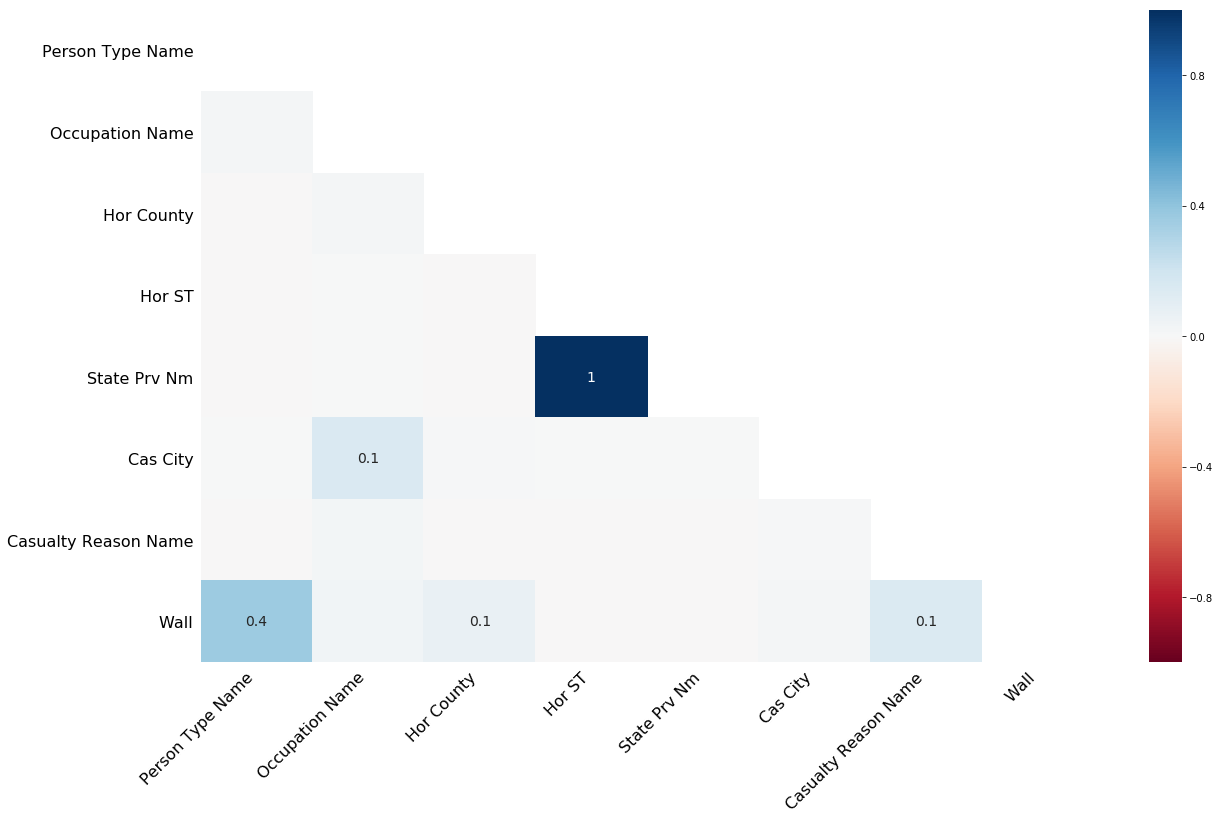

In [36]:
msno.heatmap(war_file)

As we can see, with the help of my dandy library `missingno`, there is 1:1 correlation with the columns `State Prv Nm` and `Hor ST`. Lets explore what is going on here.

In [37]:
war_file[war_file['State Prv Nm'].isna() == True]['Hor Ctry'].value_counts()

CA    56
RP    26
GM     7
MX     5
UK     3
JA     2
JM     2
FR     2
NZ     2
PM     2
AS     2
IT     1
SZ     1
BF     1
PE     1
EI     1
BL     1
BR     1
CS     1
Name: Hor Ctry, dtype: int64

These have been confirmed to be other country codes. These soliders were foriegn nationals fighting in our war. It isn't unheard of it. So I will make their "State Prv Nm" to "FOREIGN".

- **Cleaning Hor County column**

In [38]:
war_file['Hor County'].isna().sum()

29

In [39]:
war_file['Hor County'].value_counts()[:10]

LOS ANGELES     1877
MULTIPLE        1737
KINGS           1391
COOK            1350
WAYNE            993
JEFFERSON        787
PHILADELPHIA     620
MONTGOMERY       577
ORANGE           546
MARION           438
Name: Hor County, dtype: int64

In [40]:
war_file[war_file['Hor County'] == 'MULTIPLE'].head()

,Person Type Name,Member Name,Service Name,Rank Rate,PG,Occupation Name,Birth Dt,G,Hor County,Hor Ctry,Hor ST,State Prv Nm,Marital Status,Cas City,Cas Ctry,Death Dt,Casualty Category,Casualty Reason Name,Body,RecoveredCasualty Closure Name,Wall
23,SELECTED SERVICE,ABBOTT JAMES EDWARD,ARMY,PVT,E02,INFANTRYMAN,1949-02-20,M,MULTIPLE,US,LA,LOUISIANA,NEVER MARRIED,BINH DUONG,VS,1970-04-09,KILLED IN ACTION,SMALL ARMS FIRE,Y,BURIED - UNKNOWN DISP,12W 110
68,ACTIVE - GUARD/RESERVE,ABRAMS JOHN ALAN,MARINE CORPS,LCPL,E03,RIFLEMAN,1946-02-20,M,MULTIPLE,US,IL,ILLINOIS,MARRIED,THUA THIEN,VS,1967-01-09,ACCIDENT,OTHER ACCIDENT,Y,BURIED - UNKNOWN DISP,13E 129
88,ACTIVE - REGULAR,JENKINS MORRIS E,ARMY,SP5,E05,GENERAL VEHICLE REPAIRMAN,1941-11-29,M,MULTIPLE,US,OH,OHIO,NEVER MARRIED,NaN,VS,1965-12-02,KILLED IN ACTION,EXPLOSIVE DEVICE,Y,BURIED - UNKNOWN DISP,03E 120
91,ACTIVE - REGULAR,JENKINS RANDALL LEE,MARINE CORPS,LCPL,E03,RIFLEMAN,1950-04-19,M,MULTIPLE,US,OH,OHIO,NEVER MARRIED,QUANG NAM,VS,1969-02-02,ACCIDENT,DROWNING,Y,BURIED - UNKNOWN DISP,33W 041
132,ACTIVE - GUARD/RESERVE,ACEVEDO-RECHANI RAFAEL,ARMY,MAJ,O04,NaN,1927-01-27,M,MULTIPLE,US,PR,PUERTO RICO,NEVER MARRIED,NaN,VS,1965-12-03,ILLNESS,INFECTIOUS DISEASE,Y,BURIED - UNKNOWN DISP,03E 121


There are 29 missing missing values in county and there are 1737 that report "MULTIPLE" as their counties. I will fill the 29 that have empty values. I am making note that I have to figure out a way to account for the multiple county values when doing the mapping.

- **Cleaning 'Casualty Reason Name**

In [42]:
war_file['Casualty Reason Name'].value_counts()

SMALL ARMS FIRE                        18021
GRENADE                                 8047
EXPLOSIVE DEVICE                        7303
UNKNOWN                                 5356
ARTILLERY/MORTAR/ROCKET                 4806
HELICOPTER CRASH -- CREW (MC)           3278
OTHER ACCIDENT                          3126
AIRCRAFT CRASH -- CREW (MC)             2016
HELICOPTER CRASH -- PASSENGER (MC)      1683
VEHICLE CRASH (MC)                      1185
DROWNING                                1158
INFECTIOUS DISEASE                       622
AIRCRAFT CRASH -- PASSENGER (MC)         547
BURNS/SMOKE INHALATION                   485
HEART RELATED                            273
SHIP/SUBMARINE ACCIDENT AT SEA (MC)      211
STROKE                                    42
OTHER WEAPONS                             34
GUNSHOT                                    8
BLUNT FORCE                                5
MISSILE                                    3
LAND MINE                                  2
CANCER    

There is a condiserable amount as "Unknown", so converting the handfull of NaN values in this column to "Unknown".

- **Cleaning Wall**

This column represents where in the Veitnam Veterans Memorial Wall. I am going to check their online records for these 23 missing values to see if they exist. It is easy to do it by hand than code something, since it is such a small subset.

In [43]:
war_file[war_file['Wall'].isna()]

,Person Type Name,Member Name,Service Name,Rank Rate,PG,Occupation Name,Birth Dt,G,Hor County,Hor Ctry,Hor ST,State Prv Nm,Marital Status,Cas City,Cas Ctry,Death Dt,Casualty Category,Casualty Reason Name,Body,RecoveredCasualty Closure Name,Wall
1808,ACTIVE - GUARD/RESERVE,AYERS RICHARD LEE,AIR FORCE,COL,O06,PILOT,1933-02-18,M,BLACK HAWK,US,IA,IOWA,MARRIED,NaN,VS,1970-04-16,DECLARED DEAD,AIRCRAFT CRASH -- CREW (MC),N,NO REMAINS FOUND,NaN
2393,TEMP/PERM DISABILITY RETIRED LIST (OVER 120 DAYS),BARBRE BOBBY GENE,ARMY,SP4,E04,ARMOR CREWMAN,1949-09-07,M,WHITE,US,IL,ILLINOIS,MARRIED,BINH DUONG,VS,1969-05-08,KILLED IN ACTION,BLUNT FORCE,Y,BURIED - CIVILIAN CEMETERY,NaN
4298,ACTIVE - REGULAR,BLAKELY MARTIN GEORGE,NAVY,CN,E03,CONSTRUCTION MECHANIC,1945-07-11,M,SAN FRANCISCO,US,CA,CALIFORNIA,NEVER MARRIED,THUA THIEN,VS,1968-05-20,ACCIDENT,VEHICLE CRASH (MC),Y,BURIED - UNKNOWN DISP,NaN
6679,ACTIVE - REGULAR,BULLARD THOMAS C,ARMY,SP4,E04,ARMOR RECONNAISSANCE SPECIALIST,1949-10-25,M,DUVAL,US,FL,FLORIDA,MARRIED,BINH LONG,VS,1969-01-11,KILLED IN ACTION,SMALL ARMS FIRE,Y,BURIED - UNKNOWN DISP,NaN
7022,ACTIVE - GUARD/RESERVE,BURRIS DONALD DEANE JR,ARMY,CW2,W02,ATTACK HELICOPTER PILOT,1946-12-26,M,DELAWARE,US,PA,PENNSYLVANIA,NEVER MARRIED,NaN,VS,1969-12-22,KILLED IN ACTION,UNKNOWN,N,NO REMAINS FOUND,NaN
10971,ACTIVE - REGULAR,CRAMER HARRY GRIFFITH,ARMY,CPT,O03,NaN,1926-05-24,M,CAMBRIA,US,PA,PENNSYLVANIA,MARRIED,KHANH HOA,VS,1957-10-21,ACCIDENT,NaN,Y,BURIED - UNKNOWN DISP,NaN
18764,TEMP/PERM DISABILITY RETIRED LIST (120 DAYS OR...,GIVENS GEORGE BRYANT JR,MARINE CORPS,LCPL,E03,NaN,1946-10-05,M,HENDERSON,US,KY,KENTUCKY,NEVER MARRIED,NaN,VS,1966-02-22,DIED OF WOUNDS,GUNSHOT,Y,BURIED - CIVILIAN CEMETERY,NaN
19294,TEMP/PERM DISABILITY RETIRED LIST (OVER 120 DAYS),GOOSSENS RICHARD MICHAEL,MARINE CORPS,LCPL,E03,NaN,1948-12-11,M,RACINE,US,WI,WISCONSIN,MARRIED,UNKNOWN,VS,2004-09-24,DIED OF WOUNDS,EXPLOSIVE DEVICE,Y,BURIED - CIVILIAN CEMETERY,NaN
21424,NaN,HARGROVE DENNIS ODELL,ARMY,SP4,E04,NaN,1948-01-23,M,DICKSON,US,TN,TENNESSEE,NEVER MARRIED,TAY NINH,VS,1987-09-24,DIED OF WOUNDS,GUNSHOT,Y,BURIED - CIVILIAN CEMETERY,NaN
21750,ACTIVE - GUARD/RESERVE,HARRISON RONALD EDWARD,NAVY,PO3,E04,EQUIPMENT OPERATOR,1946-10-30,M,EDDY,US,NM,NEW MEXICO,NEVER MARRIED,THUA THIEN,VS,1968-05-20,ACCIDENT,VEHICLE CRASH (MC),Y,BURIED - UNKNOWN DISP,NaN


In [44]:
war_file.at[2393, 'Wall'] = '25W/29'
war_file.at[1808, 'Wall'] = '11W/12'
war_file.at[4298, 'Wall'] = '64E/3'
war_file.at[6679, 'Wall'] = '35W/69'
war_file.at[7022, 'Wall'] = '15W/81'
war_file.at[10971, 'Wall'] = '1E/78'
war_file.at[18764, 'Wall'] = '14E/63'
war_file.at[19294, 'Wall'] = '68E/4'
war_file.at[21424, 'Wall'] = '12W/114'
war_file.at[21750, 'Wall'] = '26E/70'
war_file.at[24554, 'Wall'] = '16E/109'
war_file.at[28965, 'Wall'] = '15E/26'
war_file.at[29572, 'Wall'] = '38E/32'
war_file.at[31202, 'Wall'] = '6E/111'
war_file.at[32848, 'Wall'] = '41E/64'
war_file.at[37394, 'Wall'] = '18E/53'
war_file.at[41802, 'Wall'] = '21W/38'
war_file.at[42473, 'Wall'] = '11W/14'
war_file.at[43545, 'Wall'] = '47E/54'
war_file.at[44211, 'Wall'] = '36W/43'
war_file.at[44847, 'Wall'] = '14E/95'
war_file.at[46240, 'Wall'] = '2W/133'
war_file.at[49999, 'Wall'] = '7W/73'

In [45]:
war_file.isna().sum()

Person Type Name                     3
Member Name                          0
Service Name                         0
Rank Rate                            0
PG                                   0
Occupation Name                   4207
Birth Dt                             0
G                                    0
Hor County                          29
Hor Ctry                             0
Hor ST                             117
State Prv Nm                       117
Marital Status                       0
Cas City                          9009
Cas Ctry                             0
Death Dt                             0
Casualty Category                    0
Casualty Reason Name                 8
Body                                 0
RecoveredCasualty Closure Name       0
Wall                                 0
dtype: int64

## Cleaning Results
The below represents all the decisions made on how to clean each individual column.

In [46]:
war_file['Occupation Name'].fillna('UNKNOWN', inplace=True)
war_file['Person Type Name'].fillna('ACTIVE - REGULAR', inplace=True)
war_file['Hor County'].fillna('MULTIPLE', inplace=True)
war_file['State Prv Nm'].fillna('FORIEGN', inplace=True)
war_file['Hor ST'].fillna('FORIEGN', inplace=True)
war_file['Cas City'].fillna('UNKNOWN', inplace=True)
war_file['Casualty Reason Name'].fillna('UNKNOWN', inplace=True)

In [47]:
war_file.columns

Index(['Person Type Name', 'Member Name', 'Service Name', 'Rank Rate', 'PG',
       'Occupation Name', 'Birth Dt', 'G', 'Hor County', 'Hor Ctry', 'Hor ST',
       'State Prv Nm', 'Marital Status', 'Cas City', 'Cas Ctry', 'Death Dt',
       'Casualty Category', 'Casualty Reason Name', 'Body',
       'RecoveredCasualty Closure Name', 'Wall'],
      dtype='object')

Going to rename the columns to contain no space or any upper case letter. 

In [48]:
columns = {'Person Type Name' : 'draft_type', 'Member Name': 'name', 'Service Name': 'service_branch',
       'Rank Rate': 'rank_rate', 'PG':'pay_grade', 'Occupation Name':'occupation_name', 'Birth Dt':'birthday', 'G':'gender', 'Hor County': 'county',
       'Hor Ctry': 'country', 'Hor ST': 'state_abbr' , 'State Prv Nm': 'state_full', 'Marital Status':'marital_status', 'Cas City':'province',
       'Cas Ctry': 'cas_ctry', 'Death Dt':'incident_date', 'Casualty Category': 'cas_reason',
       'Casualty Reason Name':'cas_descr', 'Body': 'body_recovered', 'RecoveredCasualty Closure Name':'closure_descr',
       'Wall':'wall'}

In [49]:
war_file.rename(columns=columns, inplace=True)

In [51]:
war_file.head()

,draft_type,name,service_branch,rank_rate,pay_grade,occupation_name,birthday,gender,county,country,state_abbr,state_full,marital_status,province,cas_ctry,incident_date,cas_reason,cas_descr,body_recovered,closure_descr,wall
0,SELECTED SERVICE,AADLAND GERALD L,ARMY,SP4,E04,INFANTRYMAN,1945-03-29,M,ROBERTS,US,SD,SOUTH DAKOTA,NEVER MARRIED,KONTUM,VS,1968-05-30,KILLED IN ACTION,SMALL ARMS FIRE,Y,BURIED - UNKNOWN DISP,63W 014
1,SELECTED SERVICE,AALUND JAMES DOWNING,ARMY,SGT,E05,INFANTRYMAN,1945-05-11,M,HARRIS,US,TX,TEXAS,NEVER MARRIED,PHUOC LONG,VS,1970-02-28,KILLED IN ACTION,ARTILLERY/MORTAR/ROCKET,Y,BURIED - UNKNOWN DISP,13W 066
2,ACTIVE - REGULAR,AAMOLD DANIEL LAWRENCE,AIR FORCE,A1C,E03,UNKNOWN,1951-08-23,M,CLAY,US,MN,MINNESOTA,NEVER MARRIED,NINH THUAN,VS,1970-08-20,ACCIDENT,OTHER ACCIDENT,Y,BURIED - UNKNOWN DISP,08W 124
3,SELECTED SERVICE,AARDE JAMES RAYMOND,MARINE CORPS,LCPL,E03,RIFLEMAN,1944-06-08,M,KING,US,WA,WASHINGTON,MARRIED,QUANG TRI,VS,1966-12-29,DIED OF WOUNDS,EXPLOSIVE DEVICE,Y,BURIED - UNKNOWN DISP,13E 095
4,SELECTED SERVICE,AARON CHARLES EDWARD,ARMY,SP4,E04,INFANTRYMAN,1948-12-12,M,MIDDLESEX,US,MA,MASSACHUSETTS,NEVER MARRIED,BINH THUAN,VS,1970-05-05,KILLED IN ACTION,GRENADE,Y,BURIED - UNKNOWN DISP,11W 098


___
## FIPS Data

This database contains FIPS information that will allow me to map all these counties.

pusedo code:  
1. Remove the columns I do not want from the FIPS DB.  
2. Merge the two smaller DFs together on the correct state, then match the county.  
3. Then merge with my master list.

In [36]:
fips_df = pd.read_csv('data/raw/county_FIPS.csv')
lat_long_df = pd.read_csv('data/raw/lat_lon_counties.csv')

In [37]:
lat_long_df.head()

,Unnamed: 0,Sort,State,FIPS,County,CountySeat(s),Population(2010),LandAreakm2,LandAreami2,WaterAreakm2,WaterAreami2,TotalAreakm2,TotalAreami2,Latitude,Longitude,Hover
0,0,1,AL,1001,Autauga,Prattville,"54,571","1,539.582",594.436,25.776,9.952,"1,565.358",604.388,32.536382,-86.644490,Autauga<br>AL<br>01001
1,1,2,AL,1003,Baldwin,Bay Minette,"182,265","4,117.522","1,589.784","1,133.190",437.527,"5,250.712","2,027.311",30.659218,-87.746067,Baldwin<br>AL<br>01003
2,2,3,AL,1005,Barbour,Clayton,"27,457","2,291.819",884.876,50.865,19.639,"2,342.684",904.515,31.870670,-85.405456,Barbour<br>AL<br>01005
3,3,4,AL,1007,Bibb,Centreville,"22,915","1,612.481",622.582,9.289,3.587,"1,621.770",626.169,33.015893,-87.127148,Bibb<br>AL<br>01007
4,4,5,AL,1009,Blount,Oneonta,"57,322","1,669.962",644.776,15.157,5.852,"1,685.119",650.628,33.977448,-86.567246,Blount<br>AL<br>01009


In [38]:
lat_long_df.drop(['Unnamed: 0', 'Sort ','CountySeat(s) ', 'FIPS ',
       'Population(2010)', 'LandAreakm2 ', 'LandAreami2 ', 'WaterAreakm2 ',
       'WaterAreami2 ', 'TotalAreakm2 ', 'TotalAreami2 ', 'Hover'], axis=1, inplace=True)

In [39]:
lat_long_df.head()

,State,County,Latitude,Longitude
0,AL,Autauga,32.536382,-86.644490
1,AL,Baldwin,30.659218,-87.746067
2,AL,Barbour,31.870670,-85.405456
3,AL,Bibb,33.015893,-87.127148
4,AL,Blount,33.977448,-86.567246


In [71]:
col = {'State':'state_abbr', 'County ': 'county', 'Latitude ':'lat', 'Longitude':'lon'}
lat_long_df.rename(columns=col, inplace=True)
lat_long_df.head()

,state_abbr,county,lat,lon
0,AL,Autauga,32.536382,-86.644490
1,AL,Baldwin,30.659218,-87.746067
2,AL,Barbour,31.870670,-85.405456
3,AL,Bibb,33.015893,-87.127148
4,AL,Blount,33.977448,-86.567246


First step down. Now just have to merge the other DF to this one.

In [72]:
fips_df.head()

,FIPS,county,state_abbr
0,01001,Autauga,AL
1,01003,Baldwin,AL
2,01005,Barbour,AL
3,01007,Bibb,AL
4,01009,Blount,AL


In [73]:
col = {"Name":'county', 'State':'state_abbr'}
fips_df = fips_df.rename(columns=col)

In [74]:
fips_df['FIPS'] = fips_df['FIPS'].apply(lambda x: str(x).zfill(5))

The line above fills in the FIPS code to contain a leading zero.

In [75]:
fips_df.head()

,FIPS,county,state_abbr
0,01001,Autauga,AL
1,01003,Baldwin,AL
2,01005,Barbour,AL
3,01007,Bibb,AL
4,01009,Blount,AL


In [76]:
fips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 3 columns):
FIPS          3232 non-null object
county        3232 non-null object
state_abbr    3232 non-null object
dtypes: object(3)
memory usage: 75.8+ KB


In [77]:
to_join_df = lat_long_df.set_index(['state_abbr', 'county'])
full_fips_df = fips_df.join(to_join_df, on = ['state_abbr', 'county'])

In [78]:
full_fips_df.county = full_fips_df.county.str.upper()

In [79]:
full_fips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 5 columns):
FIPS          3232 non-null object
county        3232 non-null object
state_abbr    3232 non-null object
lat           3021 non-null float64
lon           3021 non-null float64
dtypes: float64(2), object(3)
memory usage: 126.3+ KB


Great, now both of smaller ones are joined correctly. Now just to merge onto my large DF.

In [157]:
temp = full_fips_df.set_index(['state_abbr','county'])

In [159]:
war_file = war_file.join(temp, on=['state_abbr', 'county'], rsuffix='_r')

In [160]:
war_file.head()

,draft_type,name,service_branch,rank_rate,pay_grade,occupation_name,birthday,gender,county,country,state_abbr,state_full,marital_status,province,cas_ctry,incident_date,cas_reason,cas_descr,body_recovered,closure_descr,wall,FIPS,lat,lon
0,SELECTED SERVICE,AADLAND GERALD L,ARMY,SP4,E04,INFANTRYMAN,1945-03-29,M,ROBERTS,US,SD,SOUTH DAKOTA,NEVER MARRIED,KONTUM,VS,1968-05-30,KILLED IN ACTION,SMALL ARMS FIRE,Y,BURIED - UNKNOWN DISP,63W 014,46109,45.623397,-96.947551
1,SELECTED SERVICE,AALUND JAMES DOWNING,ARMY,SGT,E05,INFANTRYMAN,1945-05-11,M,HARRIS,US,TX,TEXAS,NEVER MARRIED,PHUOC LONG,VS,1970-02-28,KILLED IN ACTION,ARTILLERY/MORTAR/ROCKET,Y,BURIED - UNKNOWN DISP,13W 066,48201,29.857273,-95.393037
2,ACTIVE - REGULAR,AAMOLD DANIEL LAWRENCE,AIR FORCE,A1C,E03,UNKNOWN,1951-08-23,M,CLAY,US,MN,MINNESOTA,NEVER MARRIED,NINH THUAN,VS,1970-08-20,ACCIDENT,OTHER ACCIDENT,Y,BURIED - UNKNOWN DISP,08W 124,27027,46.898377,-96.494901
3,SELECTED SERVICE,AARDE JAMES RAYMOND,MARINE CORPS,LCPL,E03,RIFLEMAN,1944-06-08,M,KING,US,WA,WASHINGTON,MARRIED,QUANG TRI,VS,1966-12-29,DIED OF WOUNDS,EXPLOSIVE DEVICE,Y,BURIED - UNKNOWN DISP,13E 095,53033,47.493554,-121.832375
4,SELECTED SERVICE,AARON CHARLES EDWARD,ARMY,SP4,E04,INFANTRYMAN,1948-12-12,M,MIDDLESEX,US,MA,MASSACHUSETTS,NEVER MARRIED,BINH THUAN,VS,1970-05-05,KILLED IN ACTION,GRENADE,Y,BURIED - UNKNOWN DISP,11W 098,25017,42.479477,-71.396507


In [161]:
war_file.to_csv('data/processed/war_records_cleaned.csv')

___
End of cleaning
___

https://www.archives.gov/research/military/vietnam-war/casualty-lists/state-level-alpha.html for state by state

https://catalog.archives.gov/id/2240992 for the `.dat` file. Contains a lot of the big stuff.

https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu for the cholorplot slider

https://catalog.archives.gov/id/10643608 list and just year of operation
http://id.loc.gov/authorities/subjects/sh85143280.html 

Testing

In [28]:
ops_df = pd.read_csv('data/raw/operations_db.csv')

In [29]:
ops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 7 columns):
op_name       255 non-null object
start_date    255 non-null int64
end_date      255 non-null int64
location_1    255 non-null object
location_2    72 non-null object
location_3    20 non-null object
location_4    9 non-null object
dtypes: int64(2), object(5)
memory usage: 14.0+ KB


In [30]:
ops_df.start_date = pd.to_datetime(ops_df.start_date, format='%Y%m%d')
ops_df.end_date = pd.to_datetime(ops_df.end_date, format='%Y%m%d')

Review `.apply` with functions in Python

In [31]:
def removing_years(string_to_process):
    if re.search(r".*(?=,)", str(string_to_process)):
        thing = re.search(r".*(?=,)", str(string_to_process))
        return thing.group(0)

In [32]:
removing_years(ops_df.op_name[2])

'Operation Adams'

In [33]:
ops_df.op_name = ops_df.op_name.apply(lambda x :removing_years(x))

In [34]:
ops_df.head()

,op_name,start_date,end_date,location_1,location_2,location_3,location_4
0,Operation Abilene,1966-04-07,1966-04-10,Phuoc Tuy,NaN,NaN,NaN
1,Operation Adairsville,1968-01-31,1968-03-08,Bien Hoa,NaN,NaN,NaN
2,Operation Adams,1966-10-26,1967-03-30,Phu Yen,NaN,NaN,NaN
3,Operation Ahina,1967-05-13,1967-05-18,Binh Duong,Tay Ninh,NaN,NaN
4,Operation Aiea,1966-08-08,1966-09-01,Hau Nghia,NaN,NaN,NaN


In [35]:
ops_df.to_csv('data/processed/ops_cleaned.csv')

In [50]:
columns = {'Person Type Name' : 'draft_type', 'Member Name': 'name', 'Service Name': 'service_branch',
       'Rank Rate': 'rank_rate', 'PG':'pay_grade', 'Occupation Name':'occupation_name', 'Birth Dt':'birthday', 'G':'gender', 'Hor County': 'country',
       'Hor Ctry': 'county', 'Hor ST': 'state_abbr' , 'State Prv Nm': 'state_full', 'Marital Status':'marital_status', 'Cas City':'province',
       'Cas Ctry': 'cas_ctry', 'Death Dt':'incident_date', 'Casualty Category': 'cas_reason',
       'Casualty Reason Name':'cas_descr', 'Body': 'body_recovered', 'RecoveredCasualty Closure Name':'closure_descr',
       'Wall':'wall'}